In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("Combined Data.csv")



# Lets Explore The Dataset(EDA)

In [39]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [42]:
df['status'].value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [4]:
# Shape & datatypes
print("Dataset Shape:", df.shape)
print(df.info())

# Check nulls
print(df.isnull().sum())


Dataset Shape: (53043, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None
Unnamed: 0      0
statement     362
status          0
dtype: int64


In [5]:
#remove null values
df = df.dropna().reset_index(drop=True)


In [7]:
#clean the text
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Text cleaning function
def clean_text(text):
    # Lowercase
    text = str(text).lower()
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords & Lemmatize
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

# Apply cleaning
df['statement'] = df['statement'].apply(clean_text)

# Check results
print(df[['statement']].head())


                                           statement
0                                            oh gosh
1  trouble sleeping confused mind restless heart ...
2  wrong back dear forward doubt stay restless re...
3  ive shifted focus something else im still worried
4                im restless restless month boy mean


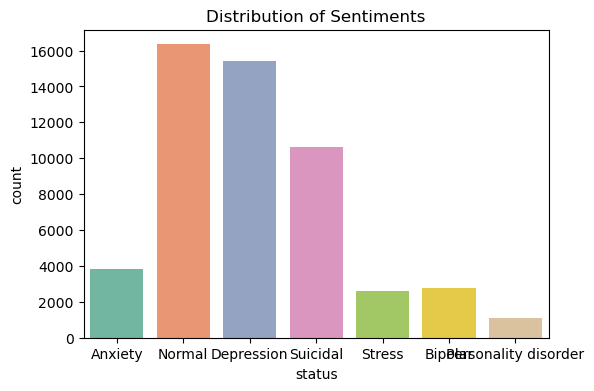

status
Normal                  0.310226
Depression              0.292401
Suicidal                0.202198
Anxiety                 0.072911
Bipolar                 0.052714
Stress                  0.049107
Personality disorder    0.020444
Name: proportion, dtype: float64


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment counts
plt.figure(figsize=(6,4))
sns.countplot(x='status', data=df, palette="Set2")  # if column is 'label'
plt.title("Distribution of Sentiments")
plt.show()

print(df['status'].value_counts(normalize=True))


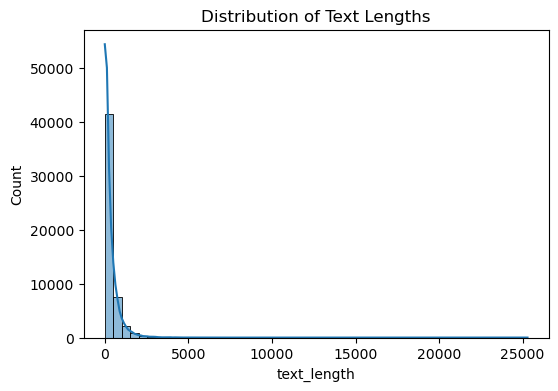

In [9]:
# Add column for text length
df['text_length'] = df['statement'].apply(len)

plt.figure(figsize=(6,4))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Distribution of Text Lengths")
plt.show()


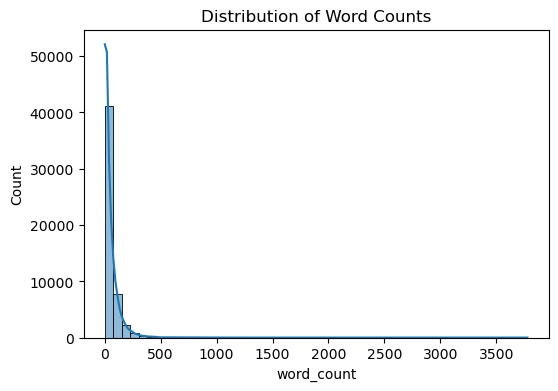

In [10]:
df['word_count'] = df['statement'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6,4))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title("Distribution of Word Counts")
plt.show()


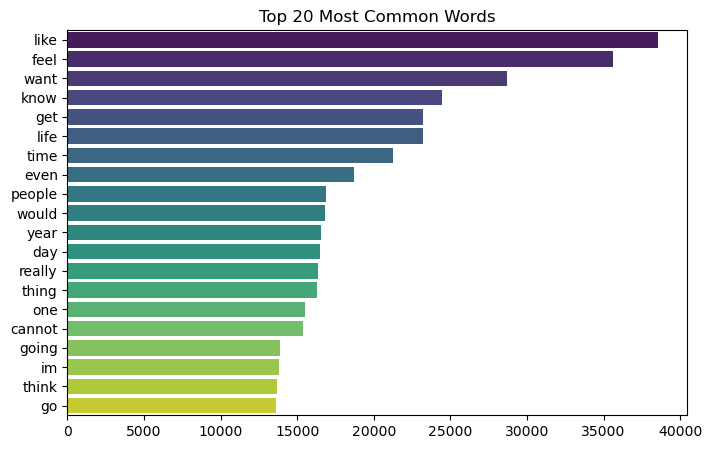

In [11]:
from collections import Counter

# Get most common words
words = " ".join(df['statement']).split()
common_words = Counter(words).most_common(20)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=[w[1] for w in common_words], y=[w[0] for w in common_words], palette="viridis")
plt.title("Top 20 Most Common Words")
plt.show()


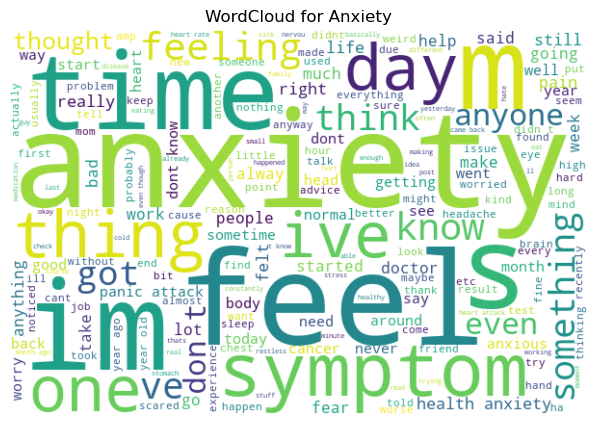

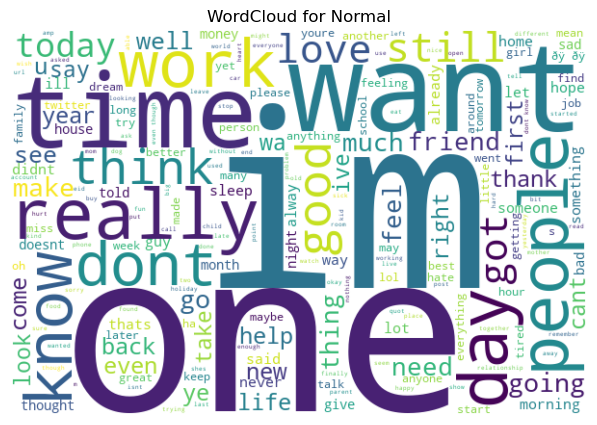

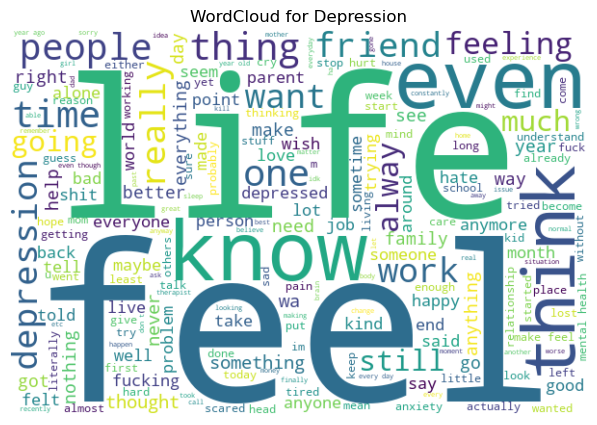

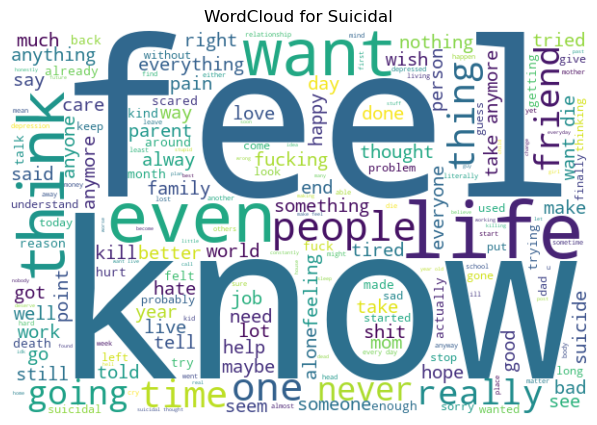

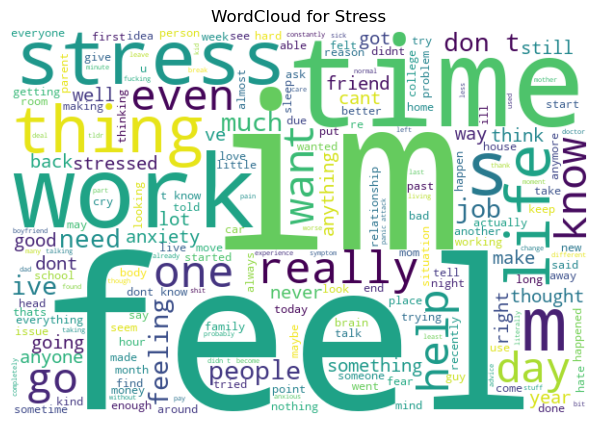

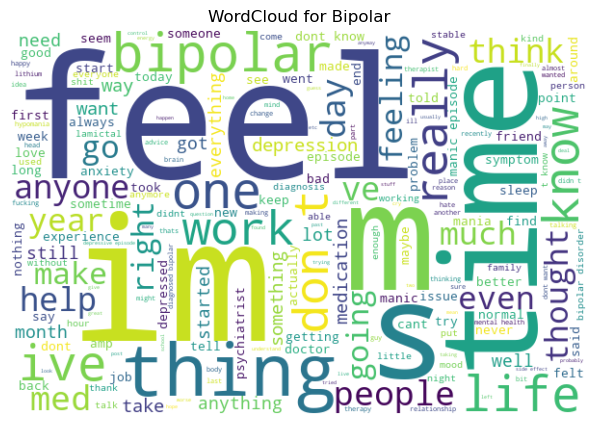

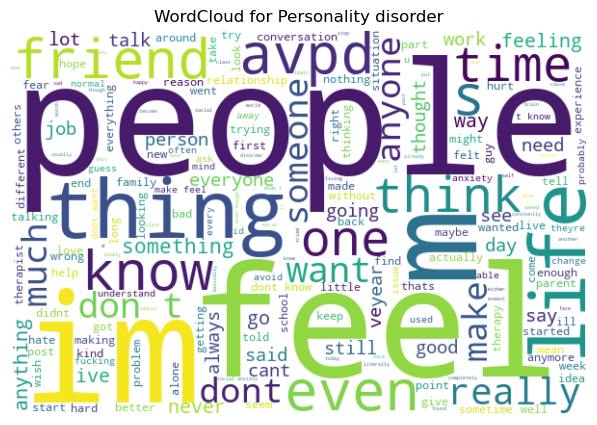

In [12]:
from wordcloud import WordCloud

for label in df['status'].unique():
    text_data = " ".join(df[df['status']==label]['statement'])
    wc = WordCloud(width=600, height=400, background_color="white").generate(text_data)

    plt.figure(figsize=(8,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {label}")
    plt.show()


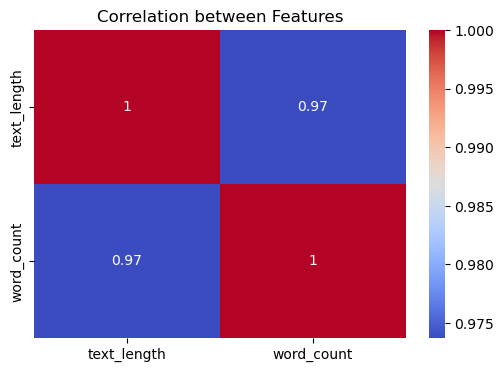

In [13]:
plt.figure(figsize=(6,4))
sns.heatmap(df[['text_length','word_count']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between Features")
plt.show()


## 🔤 Text Preprocessing: Tokenization & Train-Test Split

Before feeding our data into a neural network, we need to convert the raw text into a numerical format that the model can understand.  
This involves two important steps:

1. **Tokenization**  
   - Tokenization is the process of splitting text into smaller units (called *tokens*), usually words.  
   - We use Keras' `Tokenizer` to map each unique word in the dataset to an integer index.  
   - Example:  
     ```
     "I love deep learning" → [5, 12, 67, 89]
     ```

2. **Padding Sequences**  
   - Since sentences have different lengths, we pad them to ensure that all input sequences have the same length.  
   - This is crucial for batch processing in deep learning models.  
   - Example (max length = 100):  
     ```
     [5, 12, 67, 89] → [0, 0, 5, 12, 67, 89]
     ```

3. **Train-Test Split**  
   - To evaluate how well our model generalizes, we split the dataset into **training** and **testing** sets.  
   - The training set is used to fit the model, while the test set helps measure real-world performance.  

👉 After these steps, our text data is transformed into numerical tensors, ready to be fed into the RNN model.


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Encode labels
le = LabelEncoder()
df['status'] = le.fit_transform(df['status'])

X = df['statement'].astype(str)
y = df['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# 2. Tokenization

max_words = 20000   # vocabulary size
max_len = 150       # sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

num_classes = len(le.classes_)


# 3. Load Pretrained GloVe Embeddings
# (Download glove.6B.100d.txt from Kaggle or GloVe website)

embedding_dim = 100
embeddings_index = {}

with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coeffs

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build Model

In [16]:
# 4. Build Model
model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Training

In [17]:
# 6. Training
history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_test_pad, y_test),
    verbose=1
)


Epoch 1/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 120s 353ms/step - accuracy: 0.3572 - loss: 1.5926 - val_accuracy: 0.3863 - val_loss: 1.5393
Epoch 2/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 117s 354ms/step - accuracy: 0.4537 - loss: 1.4437 - val_accuracy: 0.5517 - val_loss: 1.2246
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 116s 351ms/step - accuracy: 0.5383 - loss: 1.1945 - val_accuracy: 0.5831 - val_loss: 0.9484
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 110s 333ms/step - accuracy: 0.6390 - loss: 0.8324 - val_accuracy: 0.6729 - val_loss: 0.8057
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 124s 376ms/step - accuracy: 0.7194 - loss: 0.6972 - val_accuracy: 0.6982 - val_loss: 0.7742
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 117s 354ms/step - accuracy: 0.7745 - loss: 0.5884 - val_accuracy: 0.7249 - val_loss: 0.7595
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 115s 348ms/step - accuracy: 0.8148 - loss: 0.5083 - val_accuracy: 0.7261 - val_loss: 0.7543
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 117s 354ms/step - accuracy: 0.8479 -

# Evaluate model

In [18]:
# 7. Evaluate
loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Accuracy: {acc:.2f}")

Test Accuracy: 0.73


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate model
loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

# Predictions (handle multiclass properly)
y_pred_probs = model.predict(X_test_pad, verbose=0)

if y_pred_probs.shape[1] > 1:  # MULTI-CLASS
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
else:  # BINARY
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()
    y_true = y_test if y_test.ndim == 1 else y_test.flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Test Loss: 0.8683
Test Accuracy: 0.7264

Classification Report:
              precision    recall  f1-score   support

           0     0.6612    0.8359    0.7384       768
           1     0.7197    0.7806    0.7489       556
           2     0.7302    0.6131    0.6665      3081
           3     0.9229    0.8755    0.8986      3269
           4     0.3346    0.4047    0.3663       215
           5     0.4533    0.5261    0.4870       517
           6     0.6079    0.6889    0.6458      2131

    accuracy                         0.7264     10537
   macro avg     0.6328    0.6750    0.6502     10537
weighted avg     0.7380    0.7264    0.7290     10537


Confusion Matrix:
[[ 642   33   20   14   18   37    4]
 [  47  434   22    4   26   19    4]
 [  61   61 1889   78   89   74  829]
 [  73    7   73 2862   14  143   97]
 [  21   45   20    6   87   33    3]
 [ 117   16   47   33   22  272   10]
 [  10    7  516  104    4   22 1468]]


# prediction on sample sentiment on our model

In [20]:
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(pad, verbose=0)
    label = le.inverse_transform([np.argmax(pred)])
    return label[0]

print(predict_sentiment("I do not know where to go, or what to do, or who to call when I get like this. I feel like an asshole for not knowing what a sense of comfort is. Maybe covering myself in warm blankets mimics the feelings, I have seen that on a Reddit post before. Why is venting and talking about problems so much easier when no one knows your name? that is why I am here in the first place. Why is venting and talking about problems so much easier when no one knows your name?"))


6


# saving the model

In [21]:
#save the model 
model.save("sentiment_model.h5")
#also save the tokenizer


In [22]:
#save the tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
# Save in native Keras format
model.save("sentiment_model.keras")


In [45]:
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences   # ✅ Fix

# Load model
model = load_model("sentiment_model.keras")

# Load tokenizer
tokenizer = joblib.load("tokenizer.pickle")

# Load label encoder
le = joblib.load("labelencoder.pickle")

def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=150)  # use same maxlen as training
    pred = model.predict(pad, verbose=0)
    label = le.inverse_transform([np.argmax(pred)])
    return label[0]

print(predict_sentiment("felling well and good"))


Normal


In [25]:
#save the labelencoder
import pickle
with open('labelencoder.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)